<a href="https://colab.research.google.com/github/mhyamt/EfficientNet-Transfer-Learning/blob/main/Efficientnet_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import torch
import numpy as np
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
#from models.enet import ENet
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.optim import lr_scheduler

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


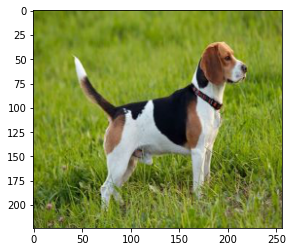

In [ ]:
img_path ='/content/drive/MyDrive/beagle2.jpeg'


plt.figure()
img = Image.open(img_path)

rsize = img.resize((256,224))

imgplot = plt.imshow(rsize)

In [ ]:
efficientnet_b0 = models.efficientnet_b0(pretrained=True)


In [ ]:
from torchvision import transforms
transform = transforms.Compose([
 transforms.Resize(256),
 transforms.CenterCrop(224),
 transforms.ToTensor(),
 transforms.Normalize(
 mean=[0.485, 0.456, 0.406],
 std=[0.229, 0.224, 0.225]
 )])


In [ ]:

img = Image.open(img_path)
img_t = transform(img)
batch_t = torch.unsqueeze(img_t, 0)
efficientnet_b0.eval()
out = efficientnet_b0(batch_t)
#print(out.shape)
with open('/content/drive/MyDrive/imagenet_classes.txt') as f:
  labels = [line.strip() for line in f.readlines()]
_, index = torch.max(out, 1)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
print(labels[index[0]], percentage[index[0]].item())
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:3]]



English foxhound 38.08350372314453


[('English foxhound', 38.08350372314453),
 ('beagle', 27.622587203979492),
 ('Walker hound, Walker foxhound', 19.599706649780273)]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/Colab Notebooks/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_conv = models.efficientnet_b0(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default

last_sequential = model_conv.classifier
num_ftrs =  list(last_sequential.children())[-1].in_features

model_conv.classifier =nn.Sequential (
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, 10),
    )

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


train Loss: 1.1614 Acc: 0.5574
val Loss: 0.7948 Acc: 0.9080

Epoch 1/24
----------
train Loss: 0.6182 Acc: 0.7500
val Loss: 0.6900 Acc: 0.8896

Epoch 2/24
----------
train Loss: 0.5242 Acc: 0.7992
val Loss: 0.5221 Acc: 0.9141

Epoch 3/24
----------
train Loss: 0.5537 Acc: 0.7623
val Loss: 0.4669 Acc: 0.9387

Epoch 4/24
----------
train Loss: 0.4344 Acc: 0.8525
val Loss: 0.4158 Acc: 0.9202

Epoch 5/24
----------
train Loss: 0.5119 Acc: 0.7869
val Loss: 0.3558 Acc: 0.9387

Epoch 6/24
----------
train Loss: 0.4344 Acc: 0.8197
val Loss: 0.3777 Acc: 0.9387

Epoch 7/24
----------
train Loss: 0.4223 Acc: 0.8279
val Loss: 0.3608 Acc: 0.9325

Epoch 8/24
----------
train Loss: 0.4440 Acc: 0.7787
val Loss: 0.3320 Acc: 0.9141

Epoch 9/24
----------
train Loss: 0.4158 Acc: 0.8074
val Loss: 0.3667 Acc: 0.9141

Epoch 10/24
----------
train Loss: 0.4749 Acc: 0.7705
val Loss: 0.3754 Acc: 0.9264

Epoch 11/24
----------
train Loss: 0.4451 Acc: 0.8156
val Loss: 0.4258 Acc: 0.9202

Epoch 12/24
----------
t